In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [13]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)
block_size = 3

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("Shape of X,Y: ", X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)

ix1 = int(0.8*len(words))
ix2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:ix1])
Xdev, Ydev = build_dataset(words[ix1:ix2])
Xte, Yte = build_dataset(words[ix2:])

Shape of X,Y:  torch.Size([182437, 3]) torch.Size([182437])
Shape of X,Y:  torch.Size([22781, 3]) torch.Size([22781])
Shape of X,Y:  torch.Size([22928, 3]) torch.Size([22928])


In [14]:
n_emb = 20
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C,W1,b1,W2,b2]
sum(p.nelement() for p in parameters)

18167

In [15]:
for p in parameters:
    p.requires_grad = True

In [16]:
# lre = torch.linspace(-3,0, 1000)
# lrs = 10**lre

lri = []
lossi = []
max_steps = 200000
batch_size = 32

In [30]:
for i in range(max_steps):
    
    #mini-batch preparation
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #zero the gradients
    for p in parameters:
        p.grad = None

    #backward pass
    loss.backward()
    
    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 31.0015
  10000/ 200000: 2.4225
  20000/ 200000: 2.4494
  30000/ 200000: 2.7295
  40000/ 200000: 2.4636
  50000/ 200000: 2.7917
  60000/ 200000: 2.3850
  70000/ 200000: 2.0974
  80000/ 200000: 2.2599
  90000/ 200000: 2.3717
 100000/ 200000: 2.3062
 110000/ 200000: 1.8194
 120000/ 200000: 1.6446
 130000/ 200000: 2.1608
 140000/ 200000: 1.7073
 150000/ 200000: 2.2525
 160000/ 200000: 1.7168
 170000/ 200000: 2.0132
 180000/ 200000: 2.6210
 190000/ 200000: 2.2341


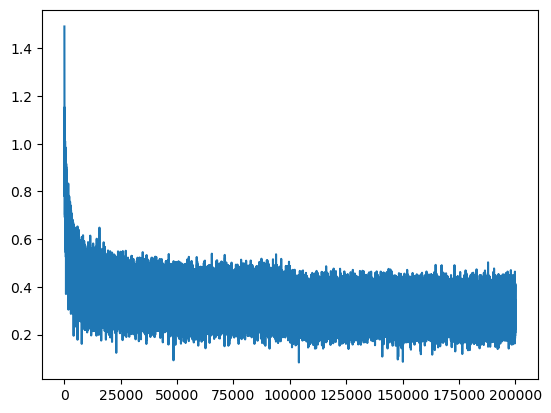

In [31]:
plt.plot(lossi)

In [34]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.076045513153076
val 2.168248176574707


In [40]:
C[torch.tensor([0]*3)].shape

torch.Size([3, 20])

In [41]:
for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[context]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

corrie.
lavae.
alaedwalleric.
izmarian.
zyannad.
ginnania.
carin.
aleslam.
ever.
graylen.
darinslee.
shonte.
paymonathviftae.
kyz.
honctorry.
lyn.
jayzon.
carlino.
bakiamayblen.
ashana.
